In [1]:
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

# Set seed for reproducible randomness
seed = 101
np.random.seed(seed)
rng = np.random.RandomState(seed)

# Pen-Tip Trajectories (Example)

This notebook aims to showcase some of the preprocessing methods and classification algorithms offered by Sequentia on the [Character Trajectories Data Set](https://archive.ics.uci.edu/ml/datasets/Character+Trajectories). This dataset consists of pen-tip trajectories generated by writing English letters on a [WACOM tablet](https://www.wacom.com/en-us). 

The **$x$-velocity**, **$y$-velocity** and **pen-tip force** were recorded.

Some more specific details about the dataset:

- The data consists of 2858 character samples
- The data has been numerically differentiated and Gaussian smoothed
- Only characters with a single 'PEN-DOWN' segment were considered (these characters are shown later)
- Characters have been shifted so that their velocity profiles best match the mean of the set

Each character sample is a 3-dimensional pen tip velocity (and force) trajectory. This is contained in matrix format, with 3 rows and $T$ columns where $T$ is the length of the character sample, which represents our observation sequence.

---

First, we will download the dataset and extract the samples and labels, then convert them so that they are in a format compatible with Sequentia (see the [_Input Format_](https://nbviewer.jupyter.org/github/eonu/sequentia/blob/master/notebooks/1%20-%20Input%20Format%20(Tutorial).ipynb) notebook for more information): 

In [2]:
data = None
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat'

try:
    path = os.path.join(os.getcwd(), 'temp.mat')
    response = requests.get(url)
except:
    raise
else:
    with open(path, 'wb') as file:
        file.write(response.content)
        data = loadmat(path)
finally:
    os.remove(path)

In [3]:
# Load the trajectories
X = [x.T for x in data['mixout'][0]] # Transpose from 3xT to Tx3
print('Number of trajectories: {}'.format(len(X)))

Number of trajectories: 2858


Only lowercase characters with a single pen-down segment were considered in this dataset. In total, there were 20 of these characters as shown below:

In [4]:
# Retrieve the set of unique labels and report the number of labels
labels = [label[0] for label in data['consts'][0][0][3][0]]
n_labels = len(labels)
print('Labels: {}'.format(str(labels)))
print('Number of labels: {}'.format(n_labels))

Labels: ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']
Number of labels: 20


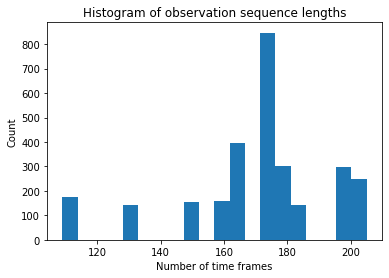

In [5]:
# View distribution of observation sequence lengths
plt.title('Histogram of observation sequence lengths')
plt.xlabel('Number of time frames')
plt.ylabel('Count')
plt.hist([len(x) for x in X], bins=n_labels)
plt.show()

The sample rate of each trajectory recording was 200hz–meaning that in every second, 200 pen-tip trajectories were recorded!

As seen in the histogram above, most characters can be drawn in less than 200 frames, or in less than one second.

Although keeping all of these frames/data-points might result in a more accurate classifier, it also significantly increases the time required for training or prediction. This is especially the case for $k$-NN, since it is a non-parametric classifier that requires going through each training example during prediction time.

---

There are three features offered by Sequentia that can help to reduce the time taken for predictions:

- Downsampling (representing each trajectory in a fewer number of frames) through two different methods:
  - **Decimation**: Only keeping the observation at every every $n$th time frame.
  - **Averaging**: Averaging every group of $n$ observations to form a single observation.
- Using a faster, restricted distance measure that can handle sequences of different length (see [FastDTW](https://pdfs.semanticscholar.org/05a2/0cde15e172fc82f32774dd0cf4fe5827cad2.pdf))
- Parallelization (only supported in the `DTWKNN` class)

The `DTWKNN` class always uses the FastDTW algorithm to calculate distances. Downsampling is offered as one of the preprocessing methods in Sequentia, and is used as follows (see the [_Preprocessing_](https://nbviewer.jupyter.org/github/eonu/sequentia/blob/master/notebooks/2%20-%20Preprocessing%20(Tutorial).ipynb) notebook for more information):

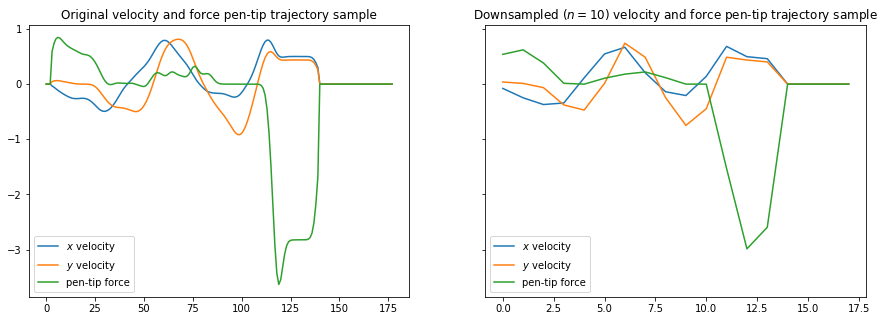

In [6]:
from sequentia.preprocessing import downsample

# Pick an example trajectory for visualization
x = X[0]
# Downsample the example trajectory, using a downsample factor of n=10
x_down = downsample(x, n=10, method='average')

# Create the plot to visualize the downsampling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.plot(x)
ax1.set_title('Original velocity and force pen-tip trajectory sample')
ax1.legend(labels=['$x$ velocity', '$y$ velocity', 'pen-tip force'])
ax2.plot(x_down)
ax2.set_title('Downsampled ($n=10$) velocity and force pen-tip trajectory sample')
ax2.legend(labels=['$x$ velocity', '$y$ velocity', 'pen-tip force'])
plt.show()

In [7]:
# Downsample the entire dataset
X = downsample(X, n=10, method='average')

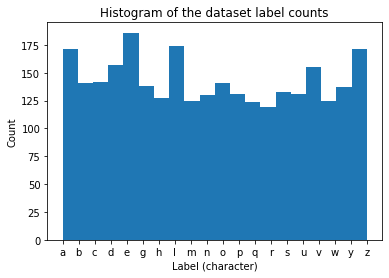

In [8]:
# Extract the labels
y = [labels[idx - 1] for idx in data['consts'][0][0][4][0]]

# Plot a histogram of the labels for each class
plt.title('Histogram of the dataset label counts')
plt.xlabel('Label (character)')
plt.ylabel('Count')
plt.hist(y, bins=n_labels)
plt.show()

In [9]:
# Shuffle and split the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, shuffle=True)
print('Training set size: {}'.format(len(X_train)))
print('Test set size: {}'.format(len(X_test)))

Training set size: 2286
Test set size: 572


In [10]:
# Create a function for displaying results (accuracy and confusion matrix)
def show_results(acc, cm, dataset):
    df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True)
    plt.title('Confusion matrix for {} set predictions'.format(dataset), fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # Fix for matplotlib bug that cuts off top/bottom of seaborn visualizations
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.show()
    print('Accuracy: {:.2f}%'.format(acc * 100))

## Dynamic Time Warping $k$-NN

The $k$-Nearest Neighbor ($k$-NN) classifier is a conceptually simple machine learning algorithm that is also easy to implement. As a result, it is often used as a baseline, despite often being able to perform much better than more complex algorithms.

However, applying $k$-NN to isolated temporal observation sequences is not so straightforward since different observation sequences may have different durations, making it difficult to come up with a distance measure that can be used to compare the two sequences. 

One such appropriate distance measure is [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping). However, due to the non-parametric nature of $k$-NN, it may take very long to predict new observation sequences. In an effort to reduce this wait, Sequentia uses the [FastDTW](https://github.com/slaypni/fastdtw) implementation of the Dynamic Time Warping algorithm, which allows for faster, configurable approximatations to the DTW distance calculations which can save memory and time. 

---

Importing, creating and fitting the classifier:

In [11]:
from sequentia.classifiers import DTWKNN

# Create and fit a DTWKNN classifier using the single nearest neighbor and a radius of 1
# NOTE: The radius parameter is a parameter that constrains the FastDTW algorithm.
clf = DTWKNN(k=1, radius=1)
clf.fit(X_train, y_train)

To predict single or multiple examples, we can use the `predict` function:

In [12]:
# Predict the first test example
clf.predict(X_test[0])

'r'

In [13]:
%%time
# Predict the first 5 test examples
clf.predict(X_test[:5])


CPU times: user 56.1 s, sys: 759 ms, total: 56.8 s
Wall time: 58.7 s


['r', 'w', 'l', 'w', 'y']

This can be sped up a bit by using multiple jobs, as specified by `n_jobs`. By default this is set to 1. A setting of -1 will use all available cores:

In [14]:
%%time
# NOTE: Progress bars for predict() and evaluate() are only displayed in the console if multiple jobs are used
clf.predict(X_test[:5], n_jobs=-1)

CPU times: user 561 ms, sys: 81.6 ms, total: 642 ms
Wall time: 41.4 s


['r', 'w', 'l', 'w', 'y']

To calculate the model's accuracy and confusion matrix on some data, we can use the `evaluate` function:

In [15]:
%%time
acc, cm = clf.evaluate(X_test, y_test, labels=labels, n_jobs=-1)

CPU times: user 616 ms, sys: 183 ms, total: 799 ms
Wall time: 1h 3min 34s


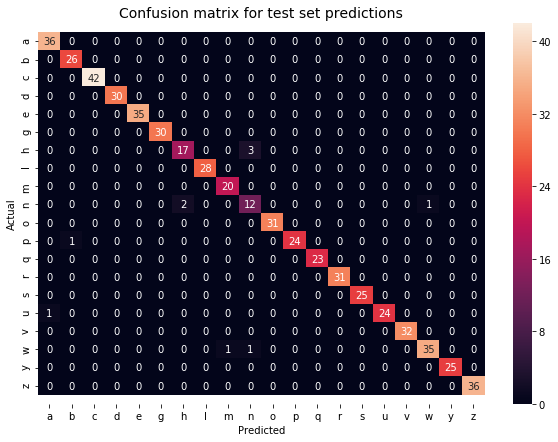

Accuracy: 98.25%


In [16]:
show_results(acc, cm, dataset='test')

As you can see, Dynamic Time Warping $k$-NN classification often works with near perfect performance, but suffers due to the fact that $k$-NN is a non-parametric machine learning algorithm. 

This means that we have to look through every training example when we make a single prediction. Even with FastDTW, downsampling and multi-processing, the example classification on the test set consisting of 572 examples **took just over an hour**!

---

As a result, parametric methods such as Hidden Markov Models are often more feasible to use–but also generally perform worse.

## Ensemble Hidden Markov Models

An ensemble of HMMs can be a good classifier for isolated sequences. The main idea behind using ensemble HMMs for classification is as follows:

1. Create $N$ HMMs $\lambda_1,\lambda_2,\ldots,\lambda_N$, each representing a different class (character in this case).
2. Fit each of these HMMs only using the training examples labeled with the class that the HMM represents. _The Baum-Welch algorithm is used for training here_.
3. For a new observation sequence $O$, calculate the likelihood of each HMM generating $O$–that is, calculate $\mathbb{P}(O|\lambda_c) \quad \forall c\in\{1, 2, \ldots, N\}$. _This is done using the Forward algorithm_.
4. Then $O$ is then classified as the class corresponding to the HMM that was most likely to generate $O$, giving a classification rule of: 

$$c^*=\mathop{\arg\max}_{c\in\{1,2,\ldots,N\}}\mathbb{P}(O|\lambda_c)$$

**Note**: In order to account for some classes naturally occurring more frequently than others, we can instead introduce a prior by using the Maximum A Posterior (MAP) classification rule:

$$c^*=\mathop{\arg\max}_{c\in\{1,2,\ldots,N\}}\mathbb{P}(O|\lambda_c)\mathbb{P}(\lambda_c)$$

---

Creating the individual `HMM` objects and fitting each one on the training examples corresponding to the label (character) that it represents:

**Note**: Here we naively set the number of states for all HMMs to 10. In reality, you will probably want to have different numbers of states for HMMs that represent more complex or more simple characters.

In [17]:
from sequentia.classifiers import HMM, HMMClassifier

hmms = []
for label in tqdm(labels, desc='Training HMMs'):
    hmm = HMM(label=label, n_states=10, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([X_train[i] for i, y_i in enumerate(y_train) if y_i == label])
    hmms.append(hmm)

A `HMMClassifier` object collects each of the individual `HMM` objects in order to create the ensemble classifier:

In [18]:
clf = HMMClassifier()
clf.fit(hmms)

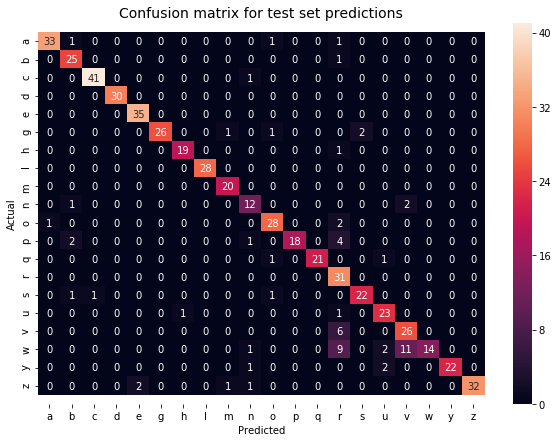

Accuracy: 88.46%


In [19]:
acc, cm = clf.evaluate(X_test, y_test, labels=labels)
show_results(acc, cm, dataset='test')